### Analysis with the trained network

This analysis uses the pretrained network. The important files are stored in

In [66]:
!ls -rtlh ~/Dropbox/Server/dl_hcs/

total 5.2G
-rw-r--r-- 1 dueo dueo 4.9M Oct  3 17:03 net_PAPER_aug_epoch512_72x72large_net.pickle
-rw-r--r-- 1 dueo dueo 5.2G Oct  3 17:04 HCS_72x72.npz
-rw-r--r-- 1 dueo dueo 414K Oct  3 17:12 permutations.np.npy


In [67]:
pretrained_net = 'net_PAPER_aug_epoch512_72x72large_net.pickle'
blob4 = 'HCS_72x72.npz' #The Scaled and cut images in the right format

In [68]:
import skimage
skimage.__version__
import gzip
import numpy as np
from sklearn.cross_validation import KFold
from sklearn.cross_validation import StratifiedKFold
import matplotlib.pyplot as plt
import matplotlib.image as imgplot
import time
%matplotlib inline
import cPickle as pickle
from lasagne import layers
from lasagne import nonlinearities
from nolearn.lasagne import NeuralNet

from nolearn.lasagne import BatchIterator

class SimpleBatchIterator(BatchIterator):

    def transform(self, Xb, yb):
        Xb, yb = super(SimpleBatchIterator, self).transform(Xb, yb)
        #return Xb[:,:,:,::-1], yb #<--- Here we do the flipping of the images
        return manipulateTrainingData(Xb), yb


with open(pretrained_net, 'rb') as f:
    net_pretrain = pickle.load(f)

## The training history

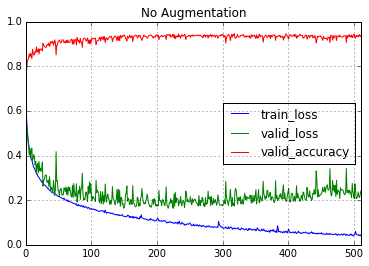

In [69]:
import pandas as pd
dfAug = pd.DataFrame(net_pretrain.train_history_)
dfAug[['train_loss','valid_loss','valid_accuracy']].plot(title='No Augmentation', ylim=(0,1))
dfAug.to_csv("complex_network_no_aug.txt")

In [70]:
np.sum(dfAug['dur']) / (60*60) #Total Training Time

19.17785088347064

The average validation accurracy over the last 100 runs was:

In [71]:
np.mean(dfAug['valid_accuracy'][451:])

0.9313015824095161

## Evaluation on the test set
### Loading and preprocessing the data

In [72]:
start = time.time()
npzfile = np.load(blob4)
cell_rows = npzfile['arr_0']
X = npzfile['arr_1']
Y = npzfile['arr_2']
print ("Loaded data in " + str(time.time() - start))

Loaded data in 10.9355950356


In [73]:
Xmean = X.mean(axis = 0)
XStd = np.sqrt(X.var(axis=0))
X = (X-Xmean)/(XStd + 0.01)

In [74]:
np.min(X), np.max(X), np.mean(X) #(-2.5272908, 58.301613, -3.3162789e-07)

(-2.5272908, 58.301613, -3.3162789e-07)

In [75]:
Y = np.asarray(Y,dtype='int32')

In [122]:
np.random.seed(seed=42)
perm1 = np.random.permutation(len(Y))
print('Sum of permutation {0}'.format(np.sum(perm1))) #1401824775
#np.save('permutations.np', perm1)
N_split = int(len(Y) * 0.8)
N_split
idx_train  = perm1[:N_split]
idx_test  = perm1[N_split:]


X_train = X[idx_train,:,:,:]
Y_train = Y[idx_train]
X_test = X[idx_test,:,:,:]
Y_test = Y[idx_test]
cell_rows_test = cell_rows[idx_test]

Sum of permutation 1401824775


In [ ]:
#with open('HCS_Test_78x78.npz', 'wb') as f:
#    np.savez(f, cell_rows_test,X_test,Y_test)

### Prediction on the test set

In [77]:
start = time.time()
pred = net_pretrain.predict(X_test)
print ("The prediction of on {} cells took {}".format(len(X_test), str(time.time() - start)))

The prediction of on 10590 cells took 6.49961304665


In [78]:
from sklearn.metrics import confusion_matrix
import pandas as pd
names = ('DMSO True', 'PACLITAXEL True', 'METOCLOPRAMIDE True', 'DIGOXIN True')
m = confusion_matrix(pred, Y_test)
df = pd.DataFrame(m)
df.columns = names
names = ('DMSO Pred', 'PACLITAXEL Pred', 'METOCLOPRAMIDE Pred', 'DIGOXIN Pred')
df.index = names
print("Total Time {}".format(1.0*np.sum(m[np.diag_indices(4)]) / np.sum(m)))
df

Total Time 0.934372049103


,DMSO True,PACLITAXEL True,METOCLOPRAMIDE True,DIGOXIN True
DMSO Pred,7775,13,208,0
PACLITAXEL Pred,28,382,23,1
METOCLOPRAMIDE Pred,414,8,1657,0
DIGOXIN Pred,0,0,0,81


In [79]:
cm_normalized = m.astype('float') / ((m.sum(axis=0)[np.newaxis,:])[0])
print('Normalized confusion matrix')
names = ('DMSO True', 'PACLITAXEL True', 'METOCLOPRAMIDE True', 'DIGOXIN True')
#m = confusion_matrix(pred, Y_test)
df = pd.DataFrame(cm_normalized)
df.columns = names
names = ('DMSO Pred', 'PACLITAXEL Pred', 'METOCLOPRAMIDE Pred', 'DIGOXIN Pred')
df.index = names
df

Normalized confusion matrix


,DMSO True,PACLITAXEL True,METOCLOPRAMIDE True,DIGOXIN True
DMSO Pred,0.946209,0.032258,0.110169,0.000000
PACLITAXEL Pred,0.003408,0.947891,0.012182,0.012195
METOCLOPRAMIDE Pred,0.050383,0.019851,0.877648,0.000000
DIGOXIN Pred,0.000000,0.000000,0.000000,0.987805


## Analysis of the wrongly predicted cells

In [80]:
pred_prob_t = net_pretrain.predict_proba(X_test)

In [81]:
pred_prob = pred_prob_t[:,0:5]
pred_prob.shape
pred_prob[1,:]

array([  1.00000000e+00,   4.48532952e-21,   6.60028787e-09,
         7.13604722e-31,   2.59952230e-31], dtype=float32)

# Global overview

How sure is the net

In [82]:
hist(np.max(pred_prob, axis=1))

### PCA

In [83]:
from sklearn import datasets
from sklearn.decomposition import PCA

explained variance ratio (first two components): [ 0.81639427  0.15586208]


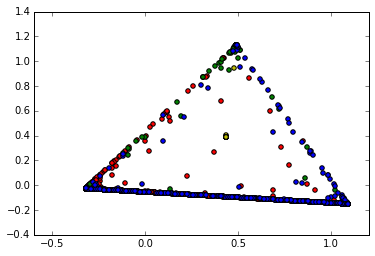

In [84]:
pca = PCA(n_components=2)
X_r = pca.fit(pred_prob).transform(pred_prob)
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))
plt.figure()
target_names = names
for c, i, target_name in zip("rgby", [0, 1, 2, 3], target_names):
    plt.scatter(X_r[Y_test == i, 0], X_r[Y_test == i, 1], c=c, label=target_name)

In [85]:
from sklearn.manifold import TSNE

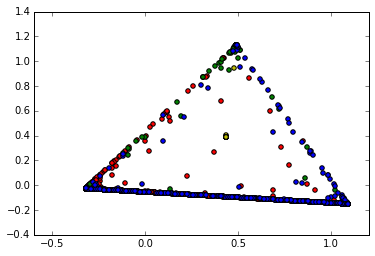

In [86]:
plt.figure()
target_names = names
for c, i, target_name in zip("rgby", [0, 1, 2, 3], target_names):
    plt.scatter(X_r[Y_test == i, 0], X_r[Y_test == i, 1], c=c, label=target_name)

In [87]:
pred_prob, Y_test

(array([[  1.00000000e+00,   1.41917297e-25,   1.52446569e-10,
           3.18534647e-36,   1.07202785e-37],
        [  1.00000000e+00,   4.48532952e-21,   6.60028787e-09,
           7.13604722e-31,   2.59952230e-31],
        [  9.98209357e-01,   1.50227194e-07,   1.79057801e-03,
           2.19877061e-10,   6.64032579e-11],
        ..., 
        [  1.00000000e+00,   4.09551611e-15,   7.18719617e-09,
           7.22068841e-24,   2.26449820e-25],
        [  1.00000000e+00,   0.00000000e+00,   1.38954555e-27,
           0.00000000e+00,   0.00000000e+00],
        [  9.99999881e-01,   2.14198759e-14,   1.04136355e-07,
           2.08903272e-21,   1.89385908e-23]], dtype=float32),
 array([0, 0, 0, ..., 0, 0, 0], dtype=int32))

In [88]:
loss = np.zeros(len(Y_test))
for i in range(len(Y_test)):
    loss[i] = pred_prob[i,Y_test[i]]
loss.shape

(10590,)

(array([  386.,    97.,    84.,    59.,    72.,    80.,   102.,   154.,
          220.,  9336.]),
 array([  1.14020393e-13,   1.00000000e-01,   2.00000000e-01,
          3.00000000e-01,   4.00000000e-01,   5.00000000e-01,
          6.00000000e-01,   7.00000000e-01,   8.00000000e-01,
          9.00000000e-01,   1.00000000e+00]),
 <a list of 10 Patch objects>)

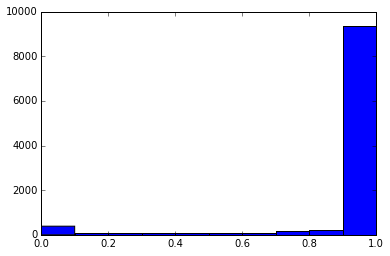

In [118]:
plt.hist(loss)

In [90]:
loss < 0.01
sum(loss < 0.01)

194

In [91]:
wrong = [loss < 0.01]

In [92]:
Y_test[wrong]

array([2, 0, 2, 0, 2, 0, 0, 2, 2, 0, 0, 1, 0, 2, 0, 0, 2, 0, 0, 2, 2, 2, 2,
       0, 2, 0, 0, 0, 2, 0, 0, 2, 2, 2, 0, 1, 2, 0, 2, 2, 0, 2, 2, 2, 0, 2,
       2, 0, 0, 0, 2, 2, 0, 0, 2, 0, 2, 2, 2, 2, 0, 0, 2, 0, 0, 2, 0, 2, 2,
       0, 2, 0, 2, 1, 0, 2, 2, 2, 2, 0, 1, 0, 2, 0, 0, 2, 2, 2, 2, 2, 0, 2,
       0, 0, 0, 0, 2, 0, 1, 2, 2, 0, 0, 0, 2, 2, 2, 2, 0, 2, 0, 2, 0, 0, 0,
       0, 2, 0, 0, 2, 0, 0, 0, 1, 2, 2, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 2, 2,
       2, 1, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 2,
       0, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 0, 2, 0, 2, 2, 0, 2, 1, 0,
       2, 0, 0, 2, 0, 0, 0, 0, 0, 2], dtype=int32)

In [124]:
def plotRows(idx, imgs = 3):
    X_idx = X_test[idx,:,:,:]
    Y_idx = Y_test[idx]
    Y_pred_idx = pred[idx]
    fig = plt.figure(figsize=(10,2*imgs))
    for i in range(imgs):#range(X_idx.shape[0]):
        dd = X_idx[i,:,:,:]
        ddd = np.transpose(dd.reshape(5*72,72))
        ax = fig.add_subplot(imgs, 1, i+1)
        ax.set_axis_off()
        ax.text(2,6,"{},{}".format(Y_idx[i], Y_pred_idx[i]),color='black', bbox={'facecolor':'white', 'alpha':0.7, 'pad':6})
        ax.imshow(ddd, interpolation='nearest')
    fig.subplots_adjust(hspace=None, wspace=None)
    plt.show()

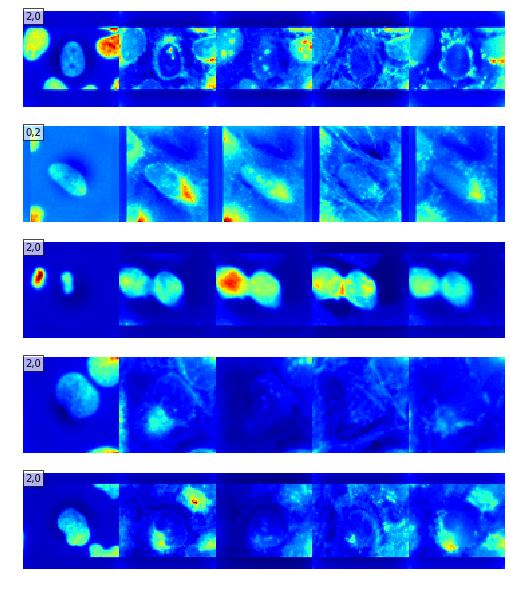

In [125]:
idx = loss < 0.02
plotRows(idx,5)

In [170]:
HOME = '/home/dueo/data/Genedata/'    #On the Datalab Server
#HOME = '/Users/oli/datasets/Genedata/ #On the MAC
cells_t = pd.read_csv(HOME + 'Cells.csv')

In [172]:
cells_t

,ImageNumber,ObjectNumber,Metadata_Channel,Metadata_Compound,Metadata_FileLocation,Metadata_Frame,Metadata_Phenotype,Metadata_Plate,Metadata_Series,Metadata_Site,...,Texture_Variance_ER_3_0,Texture_Variance_ER_5_0,Texture_Variance_Golgi_Actin_3_0,Texture_Variance_Golgi_Actin_5_0,Texture_Variance_Hoechst_3_0,Texture_Variance_Hoechst_5_0,Texture_Variance_Mito_3_0,Texture_Variance_Mito_5_0,Texture_Variance_Nucleoli_3_0,Texture_Variance_Nucleoli_5_0
0,1,1,NaN,PACLITAXEL,NaN,0,1,20585,0,1,...,0.963408,0.942669,1.432731,1.470543,2.608476,2.653153,1.357492,1.328036,1.516640,1.495042
1,1,2,NaN,PACLITAXEL,NaN,0,1,20585,0,1,...,1.070573,1.084703,1.917686,1.915602,2.261544,2.322472,1.621720,1.628327,1.489087,1.491358
2,1,3,NaN,PACLITAXEL,NaN,0,1,20585,0,1,...,0.703105,0.714262,1.621151,1.623899,1.664106,1.705266,1.610848,1.621337,1.679954,1.700747
3,1,4,NaN,PACLITAXEL,NaN,0,1,20585,0,1,...,0.878495,0.893629,2.028432,2.033459,1.902903,1.943207,1.805773,1.814701,2.316864,2.325391
4,1,5,NaN,PACLITAXEL,NaN,0,1,20585,0,1,...,1.316787,1.330969,1.780373,1.792182,1.583360,1.619792,2.144978,2.150522,2.188546,2.206693
5,1,6,NaN,PACLITAXEL,NaN,0,1,20585,0,1,...,0.539576,0.547029,0.619443,0.621007,1.200822,1.226364,0.830376,0.833998,1.662265,1.674101
6,1,7,NaN,PACLITAXEL,NaN,0,1,20585,0,1,...,0.963023,0.979858,1.829875,1.830180,1.448971,1.480549,1.988062,2.009791,2.049452,2.074722
7,1,8,NaN,PACLITAXEL,NaN,0,1,20585,0,1,...,1.615376,1.670367,1.025157,1.044319,1.195368,1.233132,1.294517,1.335664,1.401528,1.434296
8,1,9,NaN,PACLITAXEL,NaN,0,1,20585,0,1,...,1.541733,1.560041,1.994704,1.990997,2.043194,2.106477,2.605194,2.634599,2.202151,2.215279
9,1,10,NaN,PACLITAXEL,NaN,0,1,20585,0,1,...,1.178213,1.190568,1.406871,1.418717,1.183611,1.203218,1.903699,1.914429,1.672578,1.693390


In [193]:
ddd = np.asarray(cell_rows, dtype='int64')
cells = cells_t[ddd]

IndexError: indices are out-of-bounds

In [179]:
cells[0:10]

,ImageNumber,ObjectNumber,Metadata_Channel,Metadata_Compound,Metadata_FileLocation,Metadata_Frame,Metadata_Phenotype,Metadata_Plate,Metadata_Series,Metadata_Site,...,Texture_Variance_ER_3_0,Texture_Variance_ER_5_0,Texture_Variance_Golgi_Actin_3_0,Texture_Variance_Golgi_Actin_5_0,Texture_Variance_Hoechst_3_0,Texture_Variance_Hoechst_5_0,Texture_Variance_Mito_3_0,Texture_Variance_Mito_5_0,Texture_Variance_Nucleoli_3_0,Texture_Variance_Nucleoli_5_0
0,1,1,NaN,PACLITAXEL,NaN,0,1,20585,0,1,...,0.963408,0.942669,1.432731,1.470543,2.608476,2.653153,1.357492,1.328036,1.516640,1.495042
1,1,2,NaN,PACLITAXEL,NaN,0,1,20585,0,1,...,1.070573,1.084703,1.917686,1.915602,2.261544,2.322472,1.621720,1.628327,1.489087,1.491358
2,1,3,NaN,PACLITAXEL,NaN,0,1,20585,0,1,...,0.703105,0.714262,1.621151,1.623899,1.664106,1.705266,1.610848,1.621337,1.679954,1.700747
3,1,4,NaN,PACLITAXEL,NaN,0,1,20585,0,1,...,0.878495,0.893629,2.028432,2.033459,1.902903,1.943207,1.805773,1.814701,2.316864,2.325391
4,1,5,NaN,PACLITAXEL,NaN,0,1,20585,0,1,...,1.316787,1.330969,1.780373,1.792182,1.583360,1.619792,2.144978,2.150522,2.188546,2.206693
5,1,6,NaN,PACLITAXEL,NaN,0,1,20585,0,1,...,0.539576,0.547029,0.619443,0.621007,1.200822,1.226364,0.830376,0.833998,1.662265,1.674101
6,1,7,NaN,PACLITAXEL,NaN,0,1,20585,0,1,...,0.963023,0.979858,1.829875,1.830180,1.448971,1.480549,1.988062,2.009791,2.049452,2.074722
7,1,8,NaN,PACLITAXEL,NaN,0,1,20585,0,1,...,1.615376,1.670367,1.025157,1.044319,1.195368,1.233132,1.294517,1.335664,1.401528,1.434296
8,1,9,NaN,PACLITAXEL,NaN,0,1,20585,0,1,...,1.541733,1.560041,1.994704,1.990997,2.043194,2.106477,2.605194,2.634599,2.202151,2.215279
9,1,10,NaN,PACLITAXEL,NaN,0,1,20585,0,1,...,1.178213,1.190568,1.406871,1.418717,1.183611,1.203218,1.903699,1.914429,1.672578,1.693390


In [180]:
cells['Metadata_Phenotype'] == Y

ValueError: Lengths must match to compare

In [157]:
ddd = np.asarray(cell_rows[0:10], dtype='int')

In [199]:
cells = df.reindex(ddd)

In [198]:
%load_ext rpy2.ipython
%Rpush pred_prob
%Rpush Y_test
%Rpush loss
%Rpush cell_rows_test

In [201]:
%%R
save(pred_prob, Y_test, loss, cell_rows_test, file='Test.Rdata')

In [202]:
!ls -rtlh

total 8.5G
-rw-r--r-- 1 dueo dueo  2.3G Jul 28 20:17 HCS_48x48.npz
-rw-r--r-- 1 dueo dueo  2.6M Jul 29 20:43 net_aug_epoch42_91prec.pickle
-rw-r--r-- 1 dueo dueo  2.6M Jul 29 21:13 net_aug_epoch69_92prec.pickle
-rw-r--r-- 1 dueo dueo  5.2G Jul 29 21:17 HCS_72x72.npz
-rw-r--r-- 1 dueo dueo  2.6M Jul 30 01:03 net_aug_epoch300_92prec.pickle
-rw-r--r-- 1 dueo dueo  2.6M Jul 30 11:22 net_aug_epoch400_all_rot_92prec.pickle
-rw-r--r-- 1 dueo dueo  3.2M Jul 30 12:23 HCS_72x72_small_32.npz
-rw-r--r-- 1 dueo dueo 1010K Jul 30 13:10 FirstNetwork_dummy.ipynb
-rw-r--r-- 1 dueo dueo  4.9M Jul 31 09:59 net_aug_epoch400_large_net.pickle
-rw-r--r-- 1 dueo dueo   14M Jul 31 23:47 net_aug_epoch242_72x72large_net.pickle
-rw-r--r-- 1 dueo dueo  3.9M Aug  1 13:34 net_aug_epoch800_48x48_all_rot_prec93.pickle
-rw-r--r-- 1 dueo dueo   14M Aug  3 13:42 net_aug_epoch800_72x72large_net.pickle
-rw-r--r-- 1 dueo dueo  4.9M Aug  6 10:39 net_PAPER_aug_epoch512_72x72large_net.pickle
-rw-r--r-- 1 dueo dueo  928K Aug  7